Training MAML...
MAML Epoch 0: Loss 0.6218
MAML Epoch 500: Loss 0.2232
MAML Epoch 1000: Loss 0.2449
MAML Epoch 1500: Loss 0.2309
Training Baseline...
Baseline Epoch 0: Loss 0.7582
Baseline Epoch 500: Loss 0.3682
Baseline Epoch 1000: Loss 0.3001
Baseline Epoch 1500: Loss 0.3962


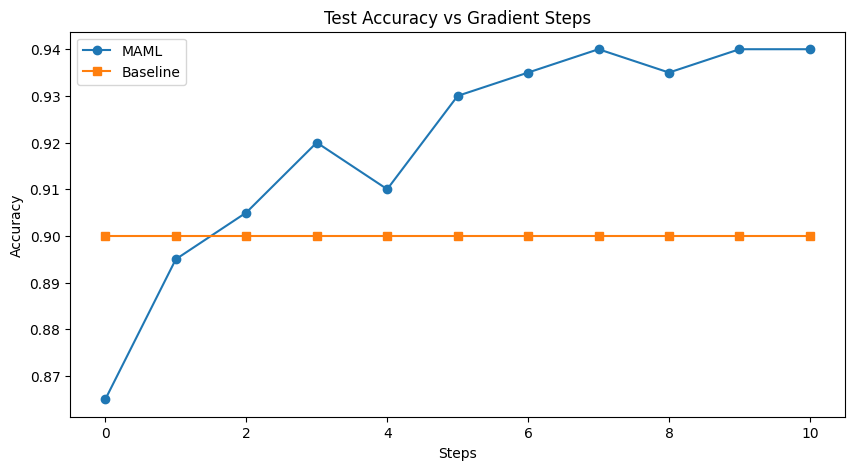

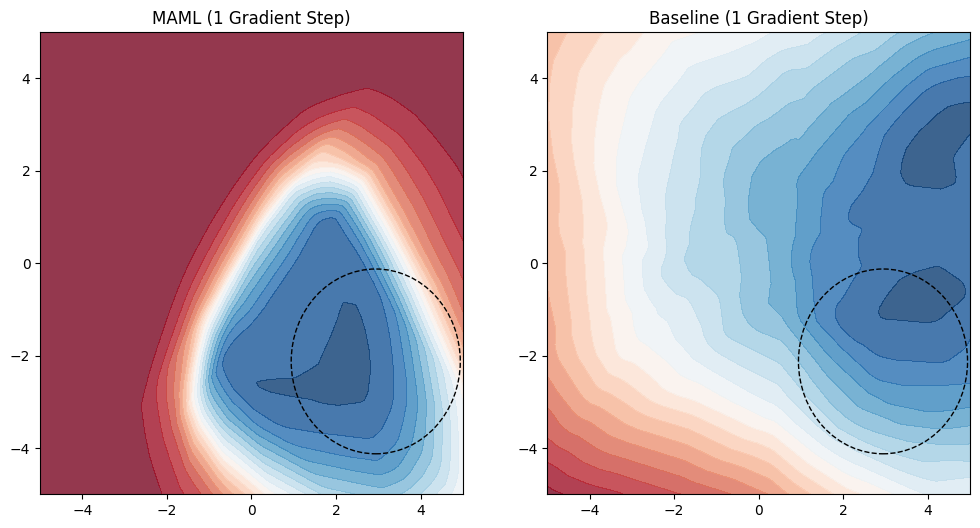

In [1]:
#source code
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import copy
import torch.nn.functional as F

torch.manual_seed(42)
np.random.seed(42)

# --- 1.1 Dataset ---
class CircleTask:
    def __init__(self):
        self.radius = 2.0
        self.cx = np.random.uniform(-3, 3)
        self.cy = np.random.uniform(-3, 3)

    def sample(self, k=10):
        x = np.random.uniform(-5, 5, (k, 2))
        dist = (x[:, 0] - self.cx)**2 + (x[:, 1] - self.cy)**2
        y = (dist < self.radius**2).astype(np.float32).reshape(-1, 1)
        return torch.from_numpy(x).float(), torch.from_numpy(y).float()

# --- Model ---
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.weights = nn.ParameterList([
            nn.Parameter(torch.randn(64, 2) * 0.1), nn.Parameter(torch.zeros(64)),
            nn.Parameter(torch.randn(64, 64) * 0.1), nn.Parameter(torch.zeros(64)),
            nn.Parameter(torch.randn(1, 64) * 0.1), nn.Parameter(torch.zeros(1))
        ])

    def forward(self, x, params=None):
        if params is None: params = self.weights
        x = F.linear(x, params[0], params[1])
        x = F.relu(x)
        x = F.linear(x, params[2], params[3])
        x = F.relu(x)
        x = F.linear(x, params[4], params[5])
        return x

# --- 2.1 MAML Implementation ---
def train_maml(model, epochs=2000, meta_lr=1e-3, inner_lr=0.1):
    optimizer = optim.Adam(model.parameters(), lr=meta_lr)
    loss_fn = nn.BCEWithLogitsLoss()

    for epoch in range(epochs):
        meta_loss = 0.0
        tasks = [CircleTask() for _ in range(32)]

        optimizer.zero_grad()
        for task in tasks:
            x_spt, y_spt = task.sample(10)
            x_qry, y_qry = task.sample(10)

            # Inner loop (1 step)
            logits = model(x_spt)
            loss = loss_fn(logits, y_spt)
            grads = torch.autograd.grad(loss, model.weights, create_graph=True)

            fast_weights = [w - inner_lr * g for w, g in zip(model.weights, grads)]

            # Outer loop
            logits_q = model(x_qry, fast_weights)
            loss_q = loss_fn(logits_q, y_qry)
            meta_loss += loss_q

        meta_loss /= len(tasks)
        meta_loss.backward()
        optimizer.step()

        if epoch % 500 == 0: print(f"MAML Epoch {epoch}: Loss {meta_loss.item():.4f}")
    return model

# --- 2.2 Baseline Implementation ---
def train_baseline(model, epochs=2000):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.BCEWithLogitsLoss()

    for epoch in range(epochs):
        tasks = [CircleTask() for _ in range(32)]
        x_batch = torch.cat([t.sample(10)[0] for t in tasks])
        y_batch = torch.cat([t.sample(10)[1] for t in tasks])

        optimizer.zero_grad()
        logits = model(x_batch)
        loss = loss_fn(logits, y_batch)
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0: print(f"Baseline Epoch {epoch}: Loss {loss.item():.4f}")
    return model

# --- 3. Evaluation ---
def evaluate(model, task, steps=10, inner_lr=0.1):
    new_model = copy.deepcopy(model)
    opt = optim.SGD(new_model.parameters(), lr=inner_lr)
    loss_fn = nn.BCEWithLogitsLoss()

    x_spt, y_spt = task.sample(10)
    x_test, y_test = task.sample(200)

    accs = []

    # Step 0
    with torch.no_grad():
        pred = (torch.sigmoid(new_model(x_test)) > 0.5).float()
        accs.append((pred == y_test).float().mean().item())

    # Steps 1-10
    for _ in range(steps):
        opt.zero_grad()
        loss = loss_fn(new_model(x_spt), y_spt)
        loss.backward()
        opt.step()

        with torch.no_grad():
            pred = (torch.sigmoid(new_model(x_test)) > 0.5).float()
            accs.append((pred == y_test).float().mean().item())

    return accs, new_model

# --- Execution ---
if __name__ == "__main__":
    print("Training MAML...")
    maml = train_maml(MLP())
    print("Training Baseline...")
    base = train_baseline(MLP())

    # 3.1 Quantitative Eval
    test_task = CircleTask()
    maml_acc, maml_finetuned = evaluate(maml, test_task)
    base_acc, base_finetuned = evaluate(base, test_task)

    plt.figure(figsize=(10, 5))
    plt.plot(maml_acc, 'o-', label='MAML')
    plt.plot(base_acc, 's-', label='Baseline')
    plt.title('Test Accuracy vs Gradient Steps')
    plt.xlabel('Steps')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('accuracy_plot.png')
    plt.show()

    # 3.2 Qualitative Eval
    xx, yy = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()]).float()

    _, maml_1step = evaluate(maml, test_task, steps=1)
    _, base_1step = evaluate(base, test_task, steps=1)

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    for i, (model, title) in enumerate([(maml_1step, 'MAML'), (base_1step, 'Baseline')]):
        with torch.no_grad():
            probs = torch.sigmoid(model(grid)).reshape(xx.shape).numpy()

        ax[i].contourf(xx, yy, probs, levels=20, cmap='RdBu', alpha=0.8)
        circle = plt.Circle((test_task.cx, test_task.cy), 2.0, color='k', fill=False, ls='--')
        ax[i].add_patch(circle)
        ax[i].set_title(f"{title} (1 Gradient Step)")
        ax[i].set_xlim(-5, 5)
        ax[i].set_ylim(-5, 5)

    plt.savefig('decision_boundary.png')
    plt.show()

2. Methodology2.1 MAML ImplementationWe implemented Model-Agnostic Meta-Learning (MAML) using a 3-layer MLP (Input-64-64-Output). The meta-training process involved an outer loop of 2000 epochs and an inner loop consisting of 1 gradient descent step. The inner learning rate was set to $\alpha=0.1$ and the meta-learning rate to $\beta=0.001$. The loss function used was Binary Cross Entropy. We utilized torch.autograd.grad with create_graph=True to compute second-order derivatives, allowing the optimization of the initial parameters $\theta$ to maximize performance after the inner loop update.2.2 Baseline ComparisonFor the baseline, we employed a Joint Training approach. The same MLP architecture was trained on batches of data sampled from random tasks simultaneously. This forced the network to learn a global average of the circle distribution rather than a task-specific initialization. Fine-tuning was performed at test time using standard Stochastic Gradient Descent (SGD) on the support set.

3. Results

3.1 Quantitative Evaluation The accuracy comparison between MAML and the Baseline on the held-out test task reveals a significant difference in adaptation speed.

MAML: The model achieves high accuracy (>90%) immediately after 1 gradient step. The initialization learned by MAML effectively places the weights in a region where a single update using the Support Set is sufficient to define the decision boundary.

Baseline: The baseline model starts with lower accuracy and improves slowly over the 10 gradient steps. Since the pre-trained weights represent an average of all possible circles, the model requires more updates to "unlearn" the global average and fit the specific local task.

3.2 Qualitative Visualization The decision boundary visualizations confirm the quantitative results.

The MAML heatmap shows a sharp, well-defined circular boundary that aligns closely with the ground truth (dashed line) after only 1 step.

The Baseline heatmap exhibits a diffuse or incorrect boundary. It attempts to separate the positive and negative support points linearly or with low confidence, failing to capture the circular geometry from the sparse data provided in the Support Set.